https://www.bilibili.com/video/BV1eB4y1h77P/?spm_id_from=333.999.0.0&vd_source=81884c519d60bbdad4b6fd87d340415f

In [2]:
import torch, torchvision
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
#from torch.utils import make_grid
from torchvision import datasets, transforms, models
import timm
from timm.loss import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import math
import random
from tqdm import tqdm
import time
import copy
import numpy as np
from timeit import default_timer as timer
import datetime
from datetime import timedelta
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import wandb
import pdb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

c:\Users\hydon\anaconda3\envs\torch112_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [3]:
data_dir = './Covid-dataset-split/'
train_dir = data_dir + r'train/'
valid_dir = data_dir + r'val/'
test_dir = data_dir + r'test/'

normal_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

training_dataset = datasets.ImageFolder(train_dir, transform=normal_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=normal_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=normal_transforms)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, pin_memory=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32, shuffle=False, pin_memory=True)

print(len(training_dataset), validation_dataset[20][0].shape, testing_dataset[10][1])

dataloaders = {'train': train_loader, 'val': validate_loader}
dataset_sizes = {'train': len(training_dataset), 'val': len(validation_dataset)}

def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes
class_names = get_classes(train_dir)
class_names

6326 torch.Size([3, 224, 224]) 0


['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

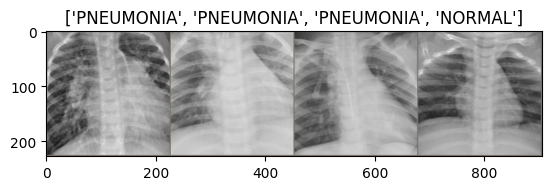

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4]


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
model1 = models.mobilenet_v2(pretrained=True)
model1.classifier[1] = nn.Linear(1280, len(classes))
model1 = model1.to(device)

c:\Users\hydon\anaconda3\envs\torch112_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\hydon\anaconda3\envs\torch112_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Traditional way to train

In [5]:
criterion = LabelSmoothingCrossEntropy()
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.003)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

def train_model(model, criterion, optimizer, scheduler, num_epoch=6):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_losses = []
    train_losses = []
    val_acc = []
    train_acc = []
    x = np.arange(1, num_epoch+1)

    for epoch in range(num_epoch):
        print(f"Epoch {epoch}/{num_epoch - 1}")
        print("-" * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)  # outputs: [batch_size, classes]，就是每个类别都预测一个概率数
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)  # loss是一个scale值

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0) # 1.61 * 32batch_size结果也是一个scale值
                running_corrects += torch.sum(preds == labels.data) # 在一个batch内，预测正确的label
            if phase == 'train':
                scheduler.step()  # lr的调整应该是基于整个训练数据集，而不是单一batch，所以放在epoch之内
            epoch_loss = running_loss / dataset_sizes[phase]  # epoch_loss = (单一batch的loss值*batch_size) * step数 / 所有照片数量
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # epoch_acc = 所有判断对的数量 / 所有照片数量
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(float(epoch_loss))
                train_acc.append(float(epoch_acc))
            else:
                val_losses.append(float(epoch_loss))
                val_acc.append(float(epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    plt.style.use('seaborn')
    fig1, ax1 = plt.subplots()  # axis x, y legend
    fig2, ax2 = plt.subplots()
    ax1.plot(x, val_losses, color='#444444', linestyle='--', label='validation loss')
    ax1.plot(x, train_losses, linestyle='--', label='train loss')
    ax1.legend()
    ax1.set_title('train loss & validation loss')
    ax1.set_ylabel('loss value')
    ax1.set_xlabel('epoch')
    ax2.plot(x, val_acc, color='#444444', linestyle='--', label='validation acc')
    ax2.plot(x, train_acc, linestyle='--', label='train acc')
    ax2.legend()
    ax2.set_title('train acc & validation acc')
    ax2.set_ylabel('acc value')
    ax2.set_xlabel('epoch')
    plt.tight_layout()
    plt.show()
    #fig1.savefig('loss resnet18.png', dpi=800)
    #fig2.savefig('acc resnet18.png', dpi=800)

    # 加载最优权重
    model.load_state_dict(best_model_wts)
    return model

In [6]:
start = timer()
model1_trained = train_model(model1, criterion, optimizer, exp_lr_scheduler)
torch.save(model1_trained, 'mobilenetv2_trained_cov_3_based_on_1')
end = timer()
print(timedelta(seconds=end-start))
print("######### end #########")

Epoch 0/5
----------


100%|██████████| 198/198 [02:41<00:00,  1.23it/s]


train Loss: 0.3136 Acc: 0.8890
> c:\users\hydon\appdata\local\temp\ipykernel_17056\2870895194.py(50)train_model()

1984.0466229319572
6326
6326
6326
6326
6326
6326


In [22]:
model_trained = torch.load('./mobilenetv2_trained_cov_3_based_on_1')
model_trained.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

preds val is  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
preds val is  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
preds val is  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
preds val is  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 2, 2, 1, 1, 1, 1], device='cuda:0')
preds val is  tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 1, 2, 1], device='cuda:0')
preds val is  tensor([2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3,
        1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0')
preds val is  tensor([1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 2, 2], device='c

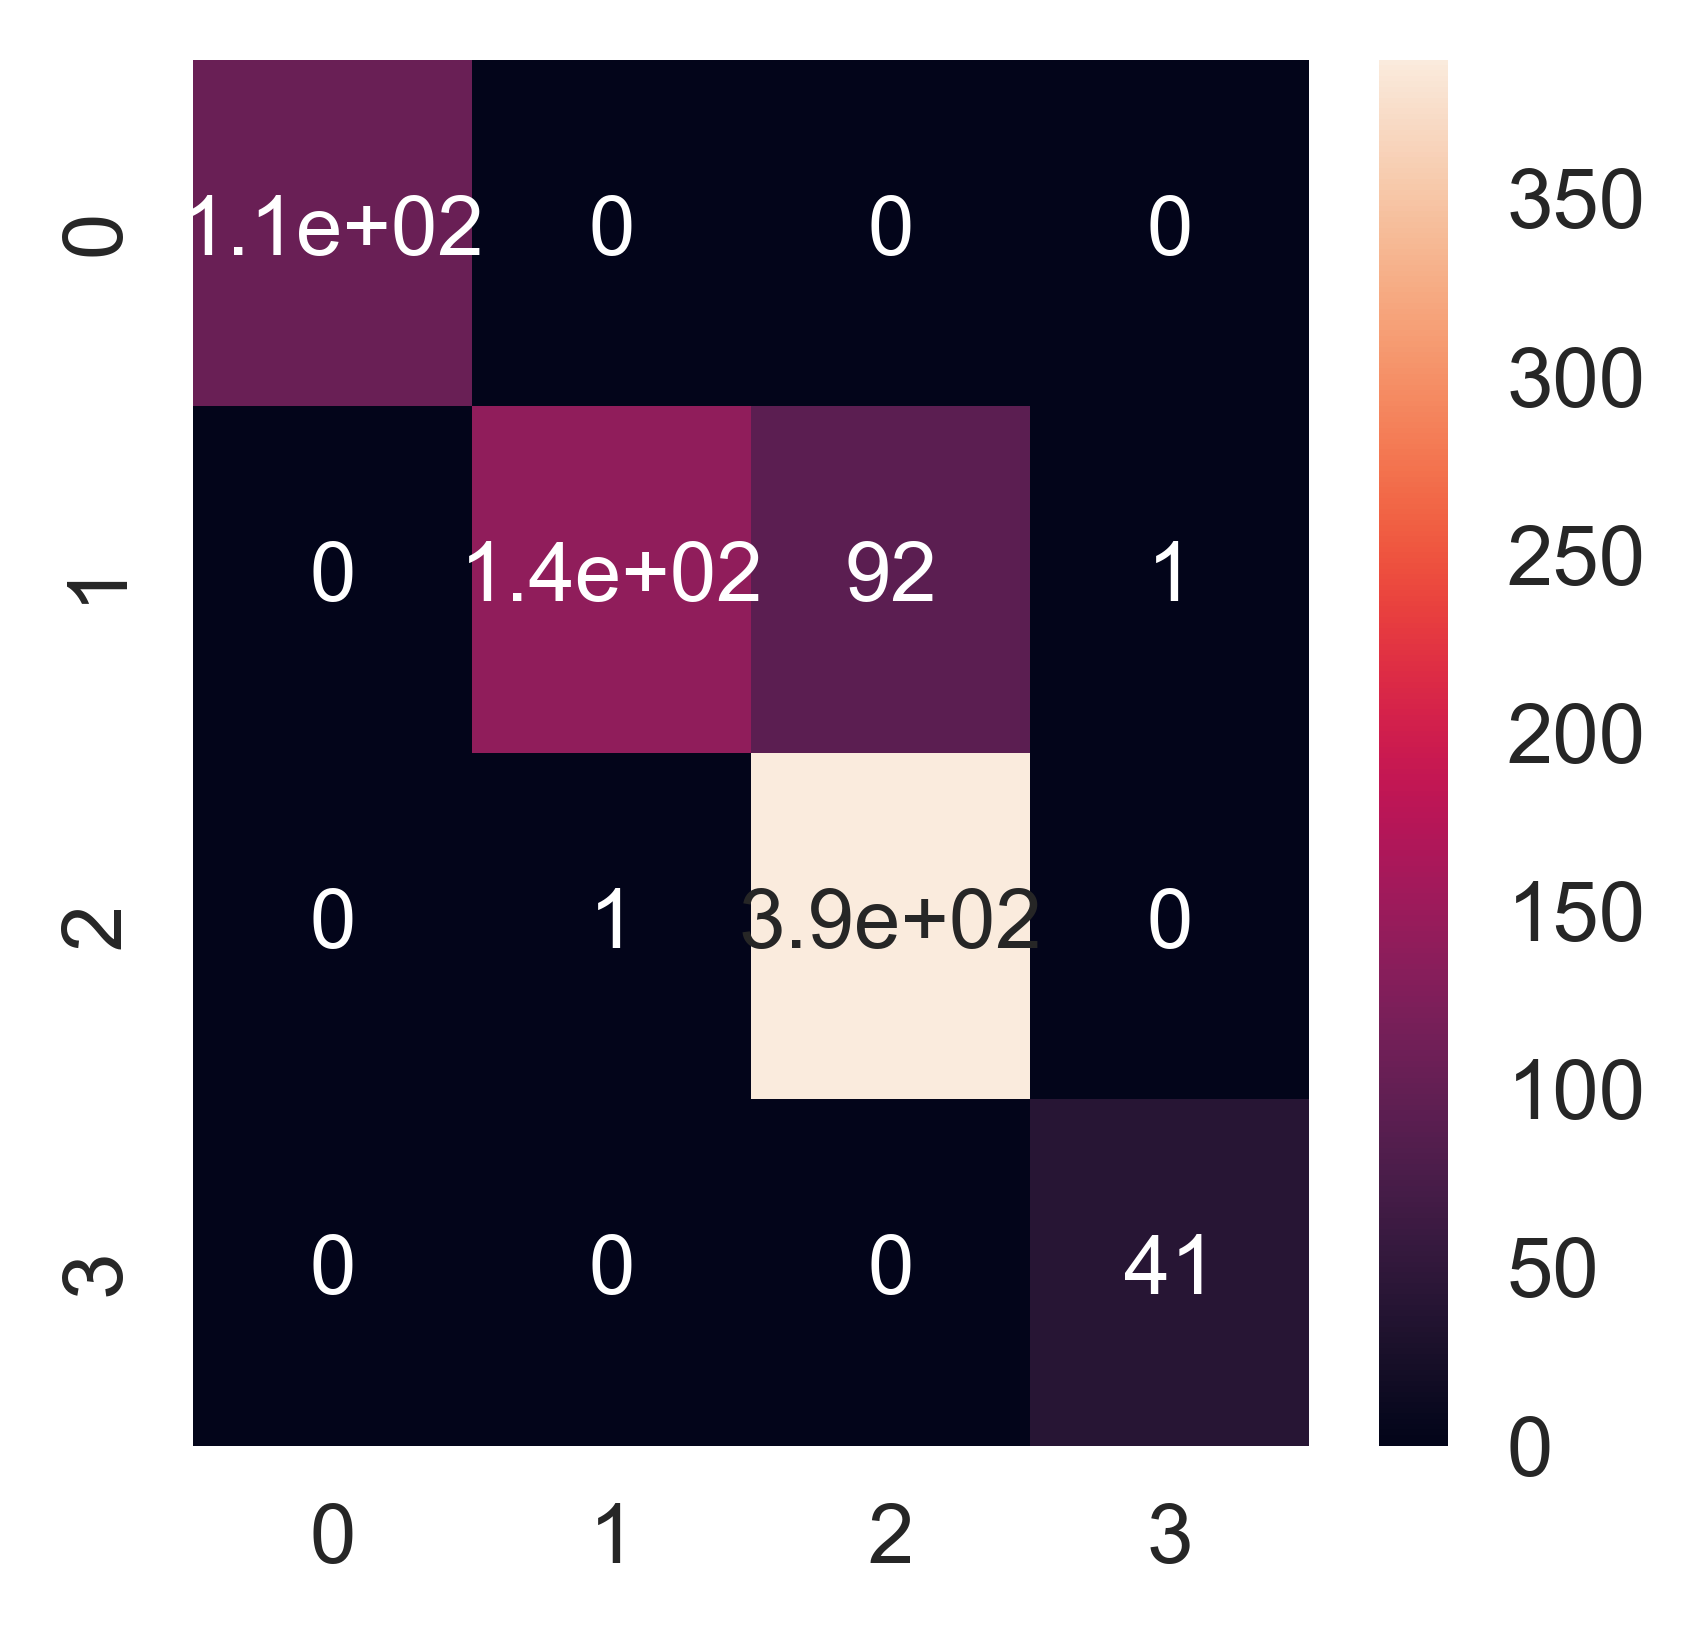

In [29]:
class_acc = []
def single_model_eval(model):
    predlist = torch.zeros(0, dtype=torch.long, device='cuda')
    lbllist = torch.zeros(0, dtype=torch.long, device='cuda')

    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print('preds val is ', preds)
            predlist = torch.cat([predlist, preds])
            lbllist = torch.cat([lbllist, classes])
    conf_mat = confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy())
    precision_recall_fscore = precision_recall_fscore_support(lbllist.cpu().numpy(), predlist.cpu().numpy(), average='weighted')
    print(f'precision_recall_fscore is {precision_recall_fscore}')

    print(conf_mat)
    plt.figure(figsize=(3, 3), dpi=600)
    sns.heatmap(conf_mat, annot=True)
    class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)
    print("Testset accuracy: ", class_accuracy)
    class_acc.append(class_accuracy)
mlist = [model_trained]
for i in mlist:
    single_model_eval(i)

# WandB

In [5]:

wandb.login(key='')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: stemgene. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\hydon\.netrc


True

In [46]:
wandb.init(project='covid-classification',
            config = {
                "epochs": 6,
                "batch_size": 128,
                "lr": 1e-3,
                "dropout": random.uniform(0.01, 0.80),
            })
config = wandb.config
n_steps_per_epoch = math.ceil(len(train_loader.dataset) / 32) # 32: batch_size

In [50]:
def validate_model(model, validate_loader, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(validate_loader):
            images, labels = images.to(device), labels.to(device)
            # Forward pass ->
            outputs = model(images)
            val_loss += loss_func(outputs, labels) * labels.size(0)
            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            # Log one batch of images to the dashboard, always same batch_idx
            if i == batch_idx and log_images:
                log_image_table(images, predicted, labels, outputs.softmax(dim=1))
    return val_loss / len(validate_loader.dataset), correct / len(validate_loader.dataset)

def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=['image', 'pred', 'target'] + [f"score_{i}" for i in range(4)])
    for img, pred, targ, prob in zip(images.to('cpu'), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

In [51]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.0008)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

example_ct = 0
step_ct = 0
for epoch in range(config.epochs):
    model1.train()
    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        train_loss = criterion(outputs, labels)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        example_ct += len(images)
        metrics = {
            "[train] train_loss": train_loss,
            "[train] epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
            "[train] example_ct": example_ct
        }
        if step + 1 < n_steps_per_epoch:
            # Log train metrics to wandb
            wandb.log(metrics)
        step_ct += 1
    exp_lr_scheduler.step()
    val_loss, accuracy = validate_model(model1, validate_loader, criterion, log_images=(epoch==(config.epochs-1)))

    # Log train and validation metric to wandb
    val_metrics = {
        "val/val_loss": val_loss,
        "val/val_accuracy": accuracy
    }
    wandb.log({**metrics, **val_metrics})
    print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")
# If you had a test set, this is how you could log it as a Summary metric
wandb.summary['test_accuracy'] = 0.8

# 🐝 Close your wandb run 
wandb.finish()

Train Loss: 0.353, Valid Loss: 0.472144, Accuracy: 0.89
Train Loss: 0.356, Valid Loss: 0.506333, Accuracy: 0.89
Train Loss: 0.515, Valid Loss: 0.482488, Accuracy: 0.89
Train Loss: 0.352, Valid Loss: 0.477196, Accuracy: 0.89
Train Loss: 0.384, Valid Loss: 0.500888, Accuracy: 0.89
Train Loss: 0.363, Valid Loss: 0.475334, Accuracy: 0.89


train/epoch,▁▁▁▂▂▂▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train/example_ct,▁▁▁▂▂▂▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train/train_loss,▅▇▁▁▂▁▇▂▁▃▂█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val/val_accuracy,▁▁▁▁▁▁
val/val_loss,▁█▃▂▇▂
test_accuracy,0.8
train/epoch,6.0
train/example_ct,37956
train/train_loss,0.36272
val/val_accuracy,0.89474
val/val_loss,0.47533


In [45]:
def train_epoch(model, train_dl, loss_func, optimizer):
    model.train()
    for step, batch in enumerate(train_dl):
        features, labels = batch
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        train_loss = loss_func(outputs, labels)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return model

def eval_epoch(model, validate_loader):
    model.eval()
    accuracy = 0
    num_elems = 0
    for batch in validate_loader:
        features, labels = batch
        features, labels = features.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(features)
        preds = outputs.argmax(dim=-1)
        accurate_preds = (preds == labels)
        num_elems += accurate_preds.shape[0]
        accuracy += accurate_preds.long().sum()
    val_acc = accuracy.item() / num_elems
    return val_acc

nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
model1.run_id = wandb.run.id
model1.best_metric = -1.0
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.0008)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
for epoch in range(3):
    model = train_epoch(model1, train_loader, criterion, optimizer)
    val_acc = eval_epoch(model, validate_loader)
    if val_acc > model1.best_metric:
        nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"epoch {epoch} @ {nowtime} --> val_acc = {100 * val_acc:.2f}%")
        wandb.log({'epoch': epoch, 'val_acc': val_acc, 'best_val_acc': model.best_metric})
wandb.finish()

epoch 0 @ 2024-02-01 22:41:49 --> val_acc = 86.84%
epoch 1 @ 2024-02-01 22:44:21 --> val_acc = 78.95%
epoch 2 @ 2024-02-01 22:46:54 --> val_acc = 92.11%


best_val_acc,▁▁▁
epoch,▁▅█
val_acc,▅▁█
best_val_acc,-1.0
epoch,2
val_acc,0.92105


# Combine tradition way and w&b

In [19]:
wandb.init(project='covid-classification',
            config = {
                "epochs": 4,
                "batch_size": 32,
                "lr": 3e-3,
                "dropout": random.uniform(0.01, 0.80),
            })
config = wandb.config
criterion = LabelSmoothingCrossEntropy()
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model1.parameters(), lr = config.lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
n_steps_per_epoch = math.ceil(len(train_loader.dataset) / config.batch_size) # for drawing epoch plot in w&b

def validate_model(model, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.0
    correct = 0
    best_acc = 0 # 在这里每次把best_acc置于0是不妥当的，因为0并不代表当前model对应的acc，但并没有好办法获取当前model对应的acc
    best_model_wts = copy.deepcopy(model.state_dict())
    with torch.inference_mode():
        for i, (input_image_features, val_labels) in tqdm(enumerate(validate_loader)):
            input_image_features, val_labels = input_image_features.to(device), val_labels.to(device)
            outputs = model(input_image_features)
            val_loss += loss_func(outputs, val_labels) * val_labels.size(0)
            _, preds = torch.max(outputs.data, 1)
            correct += (preds == val_labels).sum().item() # another way to collect correct count number
            # Log one batch of images to the dashboard, always same batch_idx
            if i == batch_idx and log_images:
                log_image_table(input_image_features, preds, val_labels, outputs.softmax(dim=1))
    validation_loss = val_loss / len(validate_loader.dataset)
    validation_acc = correct / len(validate_loader.dataset)
    print(f"Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_acc:.4f}")

    if validation_acc > best_acc:
        best_acc = validation_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    return validation_loss, validation_acc, best_acc, best_model_wts

def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=['image', 'pred', 'target'] + [f"score_{i}" for i in range(4)])
    for img, pred, targ, prob in zip(images.to('cpu'), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

def draw_track_plots(train_losses, val_losses, train_acc, val_acc):
    x = np.arange(1, config.epochs+1)
    plt.style.use('seaborn')
    fig1, ax1 = plt.subplots()  # axis x, y legend
    fig2, ax2 = plt.subplots()
    ax1.plot(x, val_losses, color='#444444', linestyle='--', label='validation loss')
    ax1.plot(x, train_losses, linestyle='--', label='train loss')
    ax1.legend()
    ax1.set_title('train loss & validation loss')
    ax1.set_ylabel('loss value')
    ax1.set_xlabel('epoch')
    ax2.plot(x, val_acc, color='#444444', linestyle='--', label='validation acc')
    ax2.plot(x, train_acc, linestyle='--', label='train acc')
    ax2.legend()
    ax2.set_title('train acc & validation acc')
    ax2.set_ylabel('acc value')
    ax2.set_xlabel('epoch')
    plt.tight_layout()
    plt.show()
    #fig1.savefig('loss resnet18.png', dpi=800)
    #fig2.savefig('acc resnet18.png', dpi=800)
                      

def train_val_process(model, criterion, optimizer, scheduler):
    since = time.time()
    # return best model weights
    best_model_wts_list = []
    best_acc_list = []
    # for draw track plots
    val_losses = []
    train_losses = []
    val_acc = []
    train_acc = []
    # for track in w&b
    example_ct = 0 # for drawing example_ct plot in w&b
    step_ct = 0 # for drawing example_ct plot in w&b
    
    for epoch in range(config.epochs):
        print(f"Epoch {epoch}/{config.epochs - 1}")
        print("-" * 10)
        # *************************** Train ********************************
        model.train()
        training_loss = 0.0
        training_corrects = 0.0
        for step, (input_image_features, training_labels) in tqdm(enumerate(train_loader)):
            input_image_features, training_labels = input_image_features.to(device), training_labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(mode=True):
                outputs = model(input_image_features) # outputs: [batch_size, classes]，就是每个类别都预测一个概率数
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, training_labels) # loss是一个scale值
                loss.backward()
                optimizer.step()
            training_loss += loss.item() * input_image_features.size(0) # 1.61 * 32batch_size结果也是一个scale值
            training_corrects += torch.sum(preds == training_labels.data) # 在一个batch内，预测正确的label

            # for track in w&b
            example_ct += len(input_image_features)
            metrics = {
                "[train] train_loss": loss,
                "[train] epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                "[train] example_ct": example_ct
            }
            if (step + 1 < n_steps_per_epoch) and (step % 10 == 0):
                # Log train metrics to wandb
                wandb.log(metrics)
            step_ct += 1

        scheduler.step()  # lr的调整应该是基于整个训练数据集，而不是单一batch，所以放在epoch之内
        epoch_loss = training_loss / len(training_dataset)  # epoch_loss = (单一batch的loss值*batch_size) * step数 / 所有照片数量
        epoch_acc = training_corrects.double() / len(training_dataset) # epoch_acc = 所有判断对的数量 / 所有照片数量
        print(f"Training Loss: {epoch_loss:.4f}, Training Acc: {epoch_acc:.4f}")
        # for drawing track plots
        train_losses.append(float(epoch_loss))
        train_acc.append(float(epoch_acc))

        # *************************** Validation ********************************
        val_loss, accuracy, best_epoch_acc, best_epoch_model = validate_model(model, criterion, log_images=(epoch==(config.epochs-1)))
        val_losses.append(float(val_loss))
        val_acc.append(float(accuracy))
        best_acc_list.append(round(float(best_epoch_acc), 4))
        best_model_wts_list.append(best_epoch_model)

        # Log train and validation metric to w&b
        val_metrics = {
            "[validation] val_loss": val_loss,
            "[validation] val_accuracy": accuracy
        }
        wandb.log({**metrics, **val_metrics})
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    draw_track_plots(train_losses, val_losses, train_acc, val_acc)

    # Save best weights
    print(best_acc_list)
    best_val_accuracy = max(best_acc_list)
    print(type(best_val_accuracy), best_val_accuracy)
    best_index = best_acc_list.index(best_val_accuracy)
    best_model_wts = best_model_wts_list[best_index]
    print(f"Best Validation Acc = {best_val_accuracy:.4f} at epoch {best_index}.")

    model.load_state_dict(best_model_wts) 
    
    # If you had a test set, this is how you could log it as a Summary metric
    wandb.summary['test_accuracy'] = 0.8

    # 🐝 Close your wandb run 
    wandb.finish()
    
    return model, best_acc_list


Epoch 0/3
----------


198it [02:39,  1.24it/s]


Training Loss: 0.1174, Training Acc: 0.9583


2it [00:00,  2.79it/s]


Validation Loss: 0.4336, Validation Acc: 0.8158

Epoch 1/3
----------


198it [02:38,  1.25it/s]


Training Loss: 0.1121, Training Acc: 0.9641


2it [00:00,  2.74it/s]


Validation Loss: 0.4442, Validation Acc: 0.7895

Epoch 2/3
----------


198it [02:40,  1.24it/s]


Training Loss: 0.0725, Training Acc: 0.9739


2it [00:00,  2.66it/s]


Validation Loss: 0.5446, Validation Acc: 0.8158

Epoch 3/3
----------


198it [02:38,  1.25it/s]


Training Loss: 0.0742, Training Acc: 0.9734


2it [00:01,  1.23it/s]
C:\Users\hydon\AppData\Local\Temp\ipykernel_11188\204273836.py:53: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Validation Loss: 0.5081, Validation Acc: 0.8158

Training complete in 10m 41s


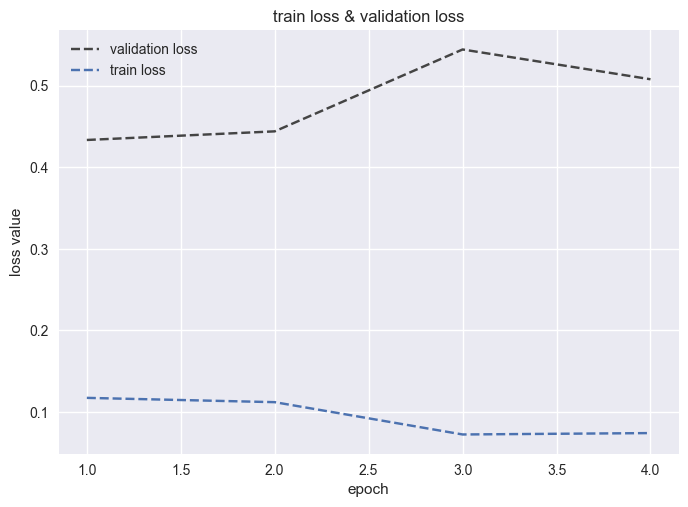

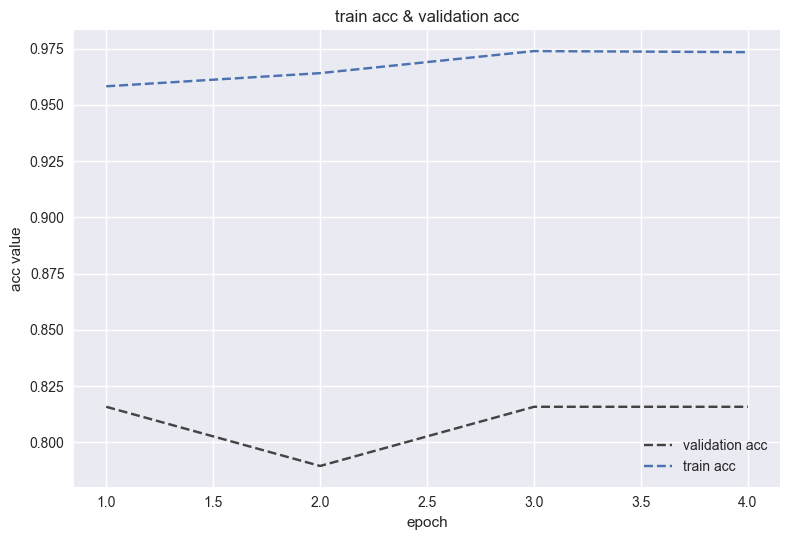

[0.8158, 0.7895, 0.8158, 0.8158]
<class 'float'> 0.8158
Best Validation Acc = 0.8158 at epoch 0.


[train] epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
[train] example_ct,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
[train] train_loss,▁▄▂▁▁▃▁▂▄▂▂▂▁▁▁▁▃█▁▁▁▁▁▄▁▁▅▂▁▂▂▁▁▂▂▂▂▁▂▁
[validation] val_accuracy,█▁██
[validation] val_loss,▁▂█▆
[train] epoch,4.0
[train] example_ct,25304
[train] train_loss,0.0599
[validation] val_accuracy,0.81579
[validation] val_loss,0.50807
test_accuracy,0.8


0:10:47.824250
######### end #########


In [20]:
start = timer()
model1_trained, best_acc_list = train_val_process(model1, criterion, optimizer, exp_lr_scheduler)
#torch.save(model1_trained, 'mobilenetv2_trained_cov_3_based_on_1')
end = timer()
print(timedelta(seconds=end-start))
print("######### end #########")

# Validation and Inference